# `Материалы кафедры ММП факультета ВМК МГУ. Введение в эффективные системы глубокого обучения.`

# `Лекция 05. Ускорение инференса: knowledge distillation, speculative decoding`

### `Материалы составил Оганов Александр (@welmud)`

#### `Москва, Осенний семестр 2025`

Материал вдохновлен лекцией Феоктистова Дмитрия (@TrandeLIk) [по ссылке](https://github.com/mmp-efml/mmp-efml-2024-fall/blob/main/presentations/lec1_knowledge_distillation.pdf) с первой итерации данного курса.

## `Мотивация`

Представим, вы обучили модель, вложили достаточно большое количество средств, но ваша основная цель — развернуть модель и дать к ней доступ. Чем меньше ресурсов потребляет модель при использовании, тем она быстрее и дешевле в использовании. Кроме того, отданные ресурсы на инференс будут зарезервированные и вы не сможете ими пользоваться.

## `Distilling the Knowledge in a Neural Network (2015)`

[Статья](https://arxiv.org/abs/1503.02531) | 27475 цитирований

`offtop` Крайне советуем почитать статью как минимум из-за автора, Geoffrey Hinton. Она начинается с фразы: "Многие насекомые ... в машинном обучении по аналогии", кроме того, в статье сравнивается BMW и мусоровоз, то есть достаточно увлекательно читать.

#### **Вопрос**. Что мы хотим от модели машинного обучения? Как мы этого добиваемся? Уточнение: представьте, что вы в 2015 году.

**Ответ.** Наша цель — получить высокое качество на всем распределении данных. Обычно же мы минимизируем функцию потерь на обучающей выборке и надеемся, что на отложенной выборке всё будет также хорошо. Обычно, мы предполагаем, что ансамбли независимых моделей имеют лучшую способность к обобщаемости.

Представим, что у нас есть ансамбль моделей, который имеет хорошую обобщаю способность, будем называть его моделью учителя (**Teacher**). Наша же цель обучить маленькую модель, будем называть её студентом (**Student**). Мы можем просто обучить модель, а можем как-то воспользоваться **Teacher**.

#### **Вопрос**. Как можно использовать модель Teacher для обучения Student? Представим, что решаем задачу классификации.

**Ответ**. Самая простая идея: если Student сможет повторить выходы Teacher, то автоматически получится хорошее качество. По сути мы можем оптимизировать $\| \mathrm{Teacher}(x) - \mathrm{Student}(x)\|^2$ по параметрам Student для всех $x$ (нам даже не важно обучающая выборка или нет, так как нам не нужна разметка). То есть мы стараемся сматчить логиты Student и Teacher.


Подход обучения модели с помощью другой умной модели называется **дистилляция знаний**. Мы хотим перенести знания из чего-то хорошо работающего в что-то маленькое и быстрое. Подход может показаться достаточно тривиальным, но давайте подумаем, что мы теперь можем делать с помощью этой концепции (да-да это можно назвать концепцией).

Начнем с простых примеров и перейдем к чему-то более сложному и интересному, например, методов которые бы **не существовали** бы без дисстиляции. Одна из таких моделей [DINO](https://arxiv.org/abs/2104.14294), поговорим о ней ближе к концу.


### `Дистилляция классификаторов`

*Перенесемся снова в 2025 год.*

Представим у нас есть модель Teacher, которая хорошо классифицирует картинки, хотим использовать её для обучения Student. Функция потерь классификации будем называть $\mathcal{L}_{\mathrm{hard}}$. Есть 3 способа, которые приходят сразу в голову, как можно дистиллировать:

1) Учить на матчинг логитов + $\mathcal{L}_{\mathrm{hard}}$;
2) Учить на матчинг вероятностей классов + $\mathcal{L}_{\mathrm{hard}}$;
3) Пункт 1 или 2, но без функции потерь классификации.

Сначала поймём, почему дистилляция вообще может помочь. Мы знаем, что в нейронные сети могут извлекать полезные знания из выборки, поэтому распределение классов предсказанное Teacher содержит полезную информацию.


Представим 2 случая:

- Класс определить просто, например, нужно отличить котенка от собак и слонов;

- Класс определить сложно, например, надо отличать мандарины от клементинов и апельсинов.

В первом случае наша задача очень простая и степень уверенности высокая (вероятность котенка $> 0.9$). 

Во втором случае модели нужно будет увидеть много мандаринов и других цитрусов, чтобы правильно классифицировать, но модель Teacher может с этим справится. Тогда, скорее всего, вероятности везде будут примерно одинаковые, но у мандарина чуть повыше. Получается по распределению выхода модели мы можем сразу понять, насколько сложный объект, а еще на какие классы он похож. Например, если мы спутали котенка от собаки, то это серьезная ошибка. Если же перепутали цитрусы, то ошибка не такая уж и серьезная и это можно простить. В случае оптимизации на $\mathcal{L}_{\mathrm{hard}}$ этой информации у нас бы не было.

С матчингом логитов всё понятно, достаточно добавить вторую норму на выходы моделей, вопрос в том, как матчить распределения классов.

#### **Вопрос**. Какую функцию потерь добавить, чтобы распределение выходов Student совпало с распределением Teacher?

**Ответ**. Если дело касается распределений, то стоит начать с KL-дивергенции. Пусть $p^T(x)$ и $p^S(x)$ распределение классов изображения $x$ на выходах Teacher и Student.

Тогда наша функция потерь будет $\mathcal{L}_{hard} + \mathrm{KL}[p^T \| p^S]$. Иными словами, для изображения $x$:

\begin{equation}
    \mathcal{L}_{hard}(x) + \sum_i p^T_i(x) \log \frac{p^T_i(x)}{p^S_i(x)}.
\end{equation}

Заметим, что мы оптимизируем только студента, тогда наша задача эквивалентна:

\begin{equation}
    \mathcal{L}_{hard}(x) - \sum_i p^T_i(x) \log p^S_i(x).
\end{equation}
По сути мы добавили кросс-энтропию между Teacher и Student.

#### **Вопрос**. Какие проблемы вы видите в такой функции потерь?

Обычные нейронные сети сильно завышают вероятности для простых примеров, то есть мы получаем вырожденное распределение $p^T$, мы хотим этого избежать. Поэтому часто используют Softmax с температурой.

\begin{equation}
\mathrm{Softmax}(z, \tau)_i = \frac{e^{\frac{z_i}{\tau}}}{\sum\limits_j e^{\frac{z_j}{\tau}} }.
\end{equation}

Чем больше температура, тем более равномерное получается распределение.

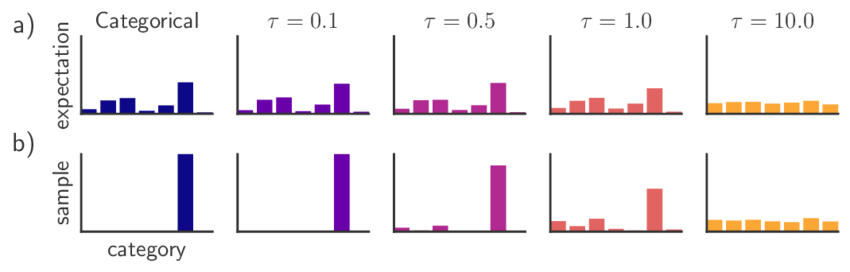

Влияние температуры на Softmax | [Источник](https://arxiv.org/abs/1611.01144)

#### `Связь логитов и вероятностей`

Выше мы обсудили, что можно просто считать вторую норму между логитами, а можно KL-дивергенцию после Softmax. Возникает вопрос, как связаны эти два способа и связаны ли они вообще. Проделаем рассуждения из секции 2.1 [статьи](https://arxiv.org/abs/1503.02531).

Для начала рассмотрим кросс-энтропию $C = \sum_i p^T_i(x) \log p^S_i(x)$, так как всё что не зависит от Student можно выбросить из задачи оптимизации.

Пусть вероятности были получены из $z_i$ логитов Student и $v_i$ логитов Teacher с температурой $\tau$, тогда будет верно:

\begin{align}
&C = \sum_i p^T_i(x) \cdot \log p^S_i(x),\\
&C = \sum_i p^T_i(x) \cdot \log \frac{e^{\frac{z_i}{\tau}}}{\sum\limits_j e^{\frac{z_j}{\tau}}},\\
&C = \sum_i p^T_i(x) \cdot \bigl[ \log e^{\frac{z_i}{\tau}} - \log \sum\limits_j e^{\frac{z_j}{\tau}} \bigr].
\end{align}

Теперь посмотри чему равен градиент, нам будет проще посмотреть сначала частную производную по $z_i$.

\begin{align}
&C = \sum_i p^T_i(x) \cdot \bigl[ \frac{z_i}{\tau} - \log \sum\limits_j e^{\frac{z_j}{\tau}} \bigr],\\
&\frac{\partial C}{\partial z_i} = p^T_i(x) \cdot \bigl[ \frac{1}{\tau} - \frac{e^{\frac{z_i}{\tau}}}{\sum\limits_j e^{\frac{z_j}{\tau}}} \frac{1}{\tau} \bigr],\\
&\frac{\partial C}{\partial z_i} = \frac{1}{\tau} \bigl[ p^T_i(x) - p^S_i(x) \bigr] = \frac{1}{\tau} \bigl[ \frac{e^{\frac{v_i}{\tau}}}{\sum\limits_j e^{\frac{v_j}{\tau}}}  - \frac{e^{\frac{z_i}{\tau}}}{\sum\limits_j e^{\frac{z_j}{\tau}}}  \bigr].
\end{align}

Упростим ещё, для этого воспользуемся разложением $e^{\frac{v_j}{\tau}}$ в Тейлора до второго порядка малости, то есть чем выше $\tau$ тем точнее аппроксимация.

\begin{align}
&\frac{\partial C}{\partial z_i} \approx \frac{1}{\tau} \bigl[ \frac{1 + \frac{v_i}{\tau}}{N + \sum\limits_j \frac{v_j}{\tau}}  - \frac{1 + \frac{z_i}{\tau}}{N + \sum\limits_j \frac{z_j}{\tau}}  \bigr],
\end{align}
где $N$ отвечает за число классов. 

Мы знаем, что результат операции Softmax не поменяется если мы вычтем из всех логитов какую-либо константу. Поэтому на самом деле, мы можем ещё упростить и представить, что мы рассматриваем центрированный Softmax. Центрированный Softmax означает, что $\sum_i z_i = \sum_i v_i = 0$ (мы всегда из логитов можем вычесть среднее и тем самым центрировать их). С использованием этого предположения мы получим:

\begin{align}
&\frac{\partial C}{\partial z_i} \approx \frac{1}{\tau} \bigl[ \frac{1 + \frac{v_i}{\tau}}{N}  - \frac{1 + \frac{z_i}{\tau}}{N}  \bigr],\\
&\frac{\partial C}{\partial z_i} \approx \frac{1}{\tau^2 N} \bigl[ v_i  - z_i \bigr],\\
\end{align}

#### **Вопрос**. На градиент какой функции похож градиент кросс-энтропии в предположении о центрирование логитов?

**Ответ**. С точностью до константы $\frac{1}{\tau^2 N}$ градиент кросс-энтропии совпадает с $\frac{1}{2}\|z - v\|_2^2$. Мы получили 2 важных факта:

1) В предположении центрированного Softmax обучение на KL-дивергенцию и матчинг логитов эквивалентно с точки градиентной оптимизации;

2) Если мы меняем температуру $\tau$ в 2 раза, то градиенты меняются в 4 раза. Поэтому чтобы градиенты не затухали при высокой температуре и всегда были одного масштаба принято умножать KL-дивергенцию на $\tau^2$. Не забывайте это делать! Это особенно важно, так как часто на практике вы обучаете на функцию потерь вида $(1 - \alpha) \cdot \mathcal{L}_{hard} + \alpha \cdot \mathrm{KL}[p^T \| p^S]$, где $\alpha$ гиперпараметр.

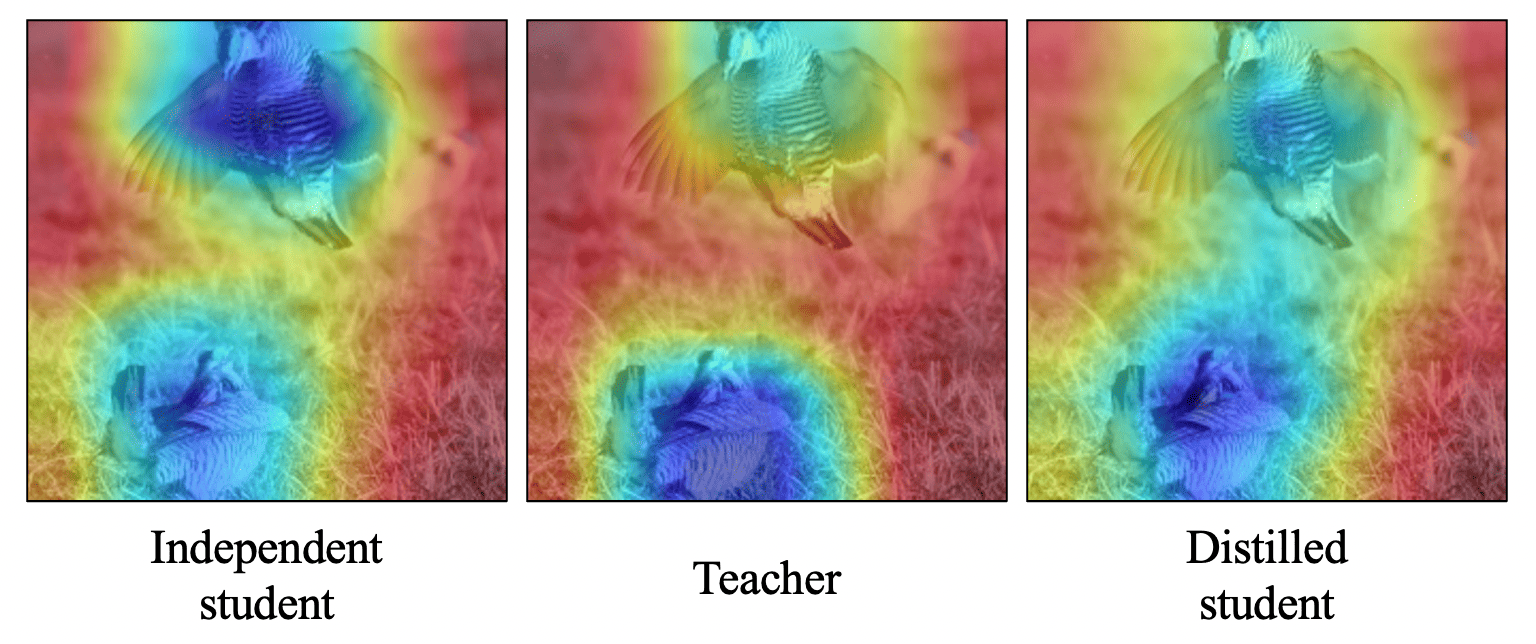

class activation map (CAM) | [Источник](https://arxiv.org/abs/2205.16004)

[Туториал о том, как дистилляция классификаторов работает в PyTorch](https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html)

#### **Вопрос**. Как вы думаете, как вы думаете, что еще можно учесть из модели Teacher? Допустим, Teacher и Student имеют одну архитектуру, но разное число слоев.

**Ответ**. Можно связать промежуточные слои. Называется такой подход был предложен в [статье](https://arxiv.org/abs/1412.6550).

### `Дистилляция BERT: DistilBERT (2020)`

[Статья](https://arxiv.org/abs/1910.01108) | 10206 цитирований

[Хороший пост про дистилляцию и DistilBERT](https://education.yandex.ru/handbook/ml/article/distillyaciya-znanij)

DistilBERT, которая сохраняет 97% качества модели BERT, при этом использует на 40% меньше параметров и требует на 60% меньше времени при применении. Всё благодаря **дистилляции**!


Что применили?

- Дистилляция на задаче маскирования (то есть задача pretrain);
- Архитектура Student такую же как и у Teacher, но с меньшим числом слоев;
- Функция потерь между промежуточными слоями;
- Инициализация слоев Student весами из Teacher (бывает трудно сделать на практике, но это повышает качество).

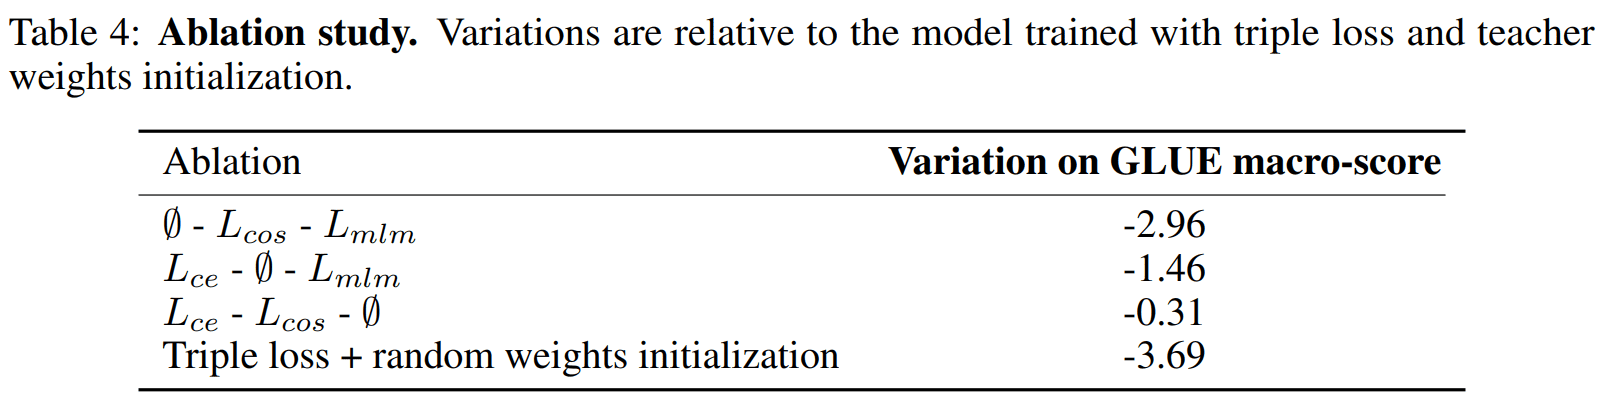

Ablation | [Источник](https://arxiv.org/abs/1910.01108)

### `Дистилляция без явного учителя: DINO (2021)`

[Статья](https://arxiv.org/abs/2104.14294) | 8544 цитирований

Раньше мы обучали модели для решения конкретных задач, например, классификация, сегментация, детекция. Иногда так оказывается, что векторные представления, полученные с помощью "хорошей модели", намного важнее, чем сама модель. При этом задача получение хорошего векторного представления, которое содержит нужную информацию, более общая, чем конкретная задача.

**Вопрос**. Какие модели для получения эмбеддингов слов вы знаете? Какие из них лучше всего сейчас работают?

**Ответ**. Если не учитывать классические методы, как word2vec и другие, то скорее всего BERT и другие трансформерные модели.

Большинство современных интересных результатов в области глубокого обучения были получены с помощью трансформеров. Давайте вспомним, что отличает трансформеры от других моделей.

**Вопрос**. Благодаря чему трансформерные архитектуры достигают превосходных результатов? Можете считать, что мы сейчас обсуждаем BERT.

**Ответ**. Во-первых, архитектура, а в частности механизм внимания (мы не будем останавливаться на смыслах и интерпретациях). Во-вторых, self-supervised pretraining (в случае BERT мы решаем задачу маскирования) благодаря, которому нам не нужны миллиарды размеченных данных для большой архитектуры.

Теперь представим, что стоит задача получения "хороших" векторных представлений изображений. Осталось понять, чему должно удовлетворять "хорошее" векторное представление изображения. В общей постановке под "хорошим" можно понимать много чего разного, например:

- Объекты одного класса были ближе, а разных далеко;
- Линейная интерполяция в латентном пространстве делает плавный переход между изображениями.

Мы бы хотели получить такие векторные представления, чтобы для разных аугментаций одного изображения, например, размера, изменения разрешения, поворота получались похожие векторные представления. Список аугментаций можно расширить до:

1) RandomHorizontalFlip;
2) ColorJitter;
3) RandomResizedCrop;
4) GaussianBlur;
5) Solarization.

Осталось понять, как выучить такую модель. Если мы возьмем изображение и построим по нему разные аугментации, например одни будут выделять локальные изображения (с RandomResizedCrop), а другие глобальные (без RandomResizedCrop), то мы ожидаем, что модель должна выдавать похожие "хорошие" эмбеддинг. 

**Вопрос**. Как вы думаете получить "хороший" эмбеддинг, который совпадает с настоящим изображением проще через локальное или глобальное изображение?

**Ответ**. Многое, конечно, зависит от аугментаций, но кажется получить эмбеддинг котенка, проще когда видно и хвост и ушки с лапками. Мы предполагаем, что наши модели умеют извлекать информацию из изображений, даже из глобального контекста, так как все строим на базе трансформерной архитектуры (например ViT).


По сути, мы хотим, чтобы вектор $f(x^{\text{local}})$ был похож на $f(x^\text{global})$, где $f(\cdot)$ нейросеть, а $x^{\text{local}}$ и $x^\text{global}$ соответственно локальные и глобальные изображения.

Похожий метод, только намного аккуратнее и точнее реализован в статье [Emerging Properties in Self-Supervised Vision Transformers](https://arxiv.org/abs/2104.14294).

**Вопрос**. Почему нам не подходит **knowledge distillation** в стандартном варианте?

**Ответ**. У нас нет модели учителя, мы лишь знаем, что, возможно, задача для $x^\text{global}$ проще и более информативная.

Поэтому в работе предлагают **knowledge DIstillation with NO labels** или кратко **DINO**. Алгоритм обучения представлен ниже.

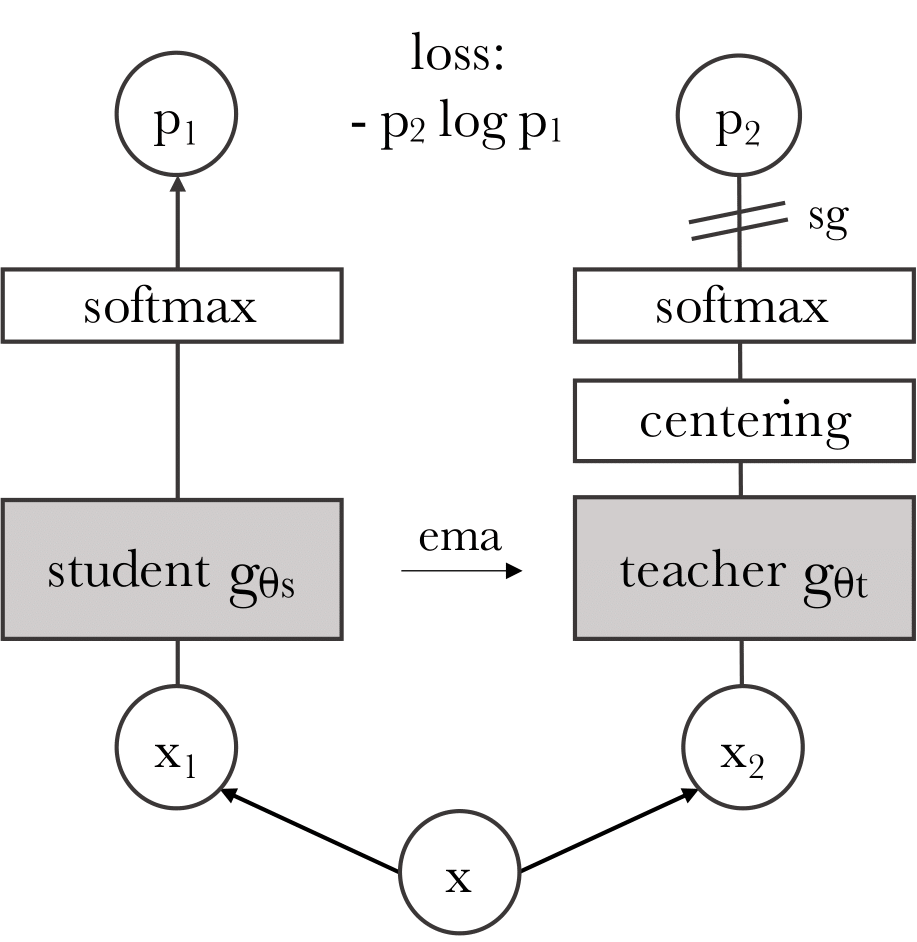

Self-distillation with no labels | [Источник](https://arxiv.org/abs/2104.14294)

Основные детали:

- $x_1$ и $x_2$ изображения, полученные с помощью различных аугментаций из изображения $x$; 
- Модель учителя и студента имеют одну архитектуру;
- Веса учителя не обучаемы и являются ema сглаженными весами студента;
- **sg** означает stop grad, то есть градиенты не проходят в модель учителя;
- Обучается на кросс-энтропию, так как наша цель, чтобы  ученик был похож по распределению на учителя;
- Важно, что $p_2 \log p_1$, а не наоборот, так как мы учим именно студента;
- Блок centering, центрирует выход teacher с учетом истории на прошлых батчах. Такой прием позволяет не вырождаться учителю и делает обучение стабильным.


**Напоминание**. Ema веса модели определяются так: $x_{\text{ema}}^{k + 1} = m \cdot x_{\text{ema}}^{k} + (1 - m) x^k$, где $x^k$ веса модели после $k$ итераций обучения. На практике на ema весах **всегда лучше метрики**. [Хорошая статья](https://arxiv.org/abs/1803.05407), где показывается связь между сглаживанием весов и широким минимум.

#### `DINO: cегментация`

С помощью такого обучения, мы действительно получим **"хорошие"** векторы, которые учитывают разные размеры и масштабы изображений. 

Вспомним ради чего мы все начали, а именно вспомним о задаче сегментации. Естественно в статье множество результатов, но нас интересует именно сегментация. Если мы хотим сегментировать объект, то наша цель выделить все пиксели связанные с ним. Для начала стоит понять, как сегментировать "самый важный" объект на изображении? Для этого стоит посмотреть self-attention для `[CLS]` токена. Пример ниже:

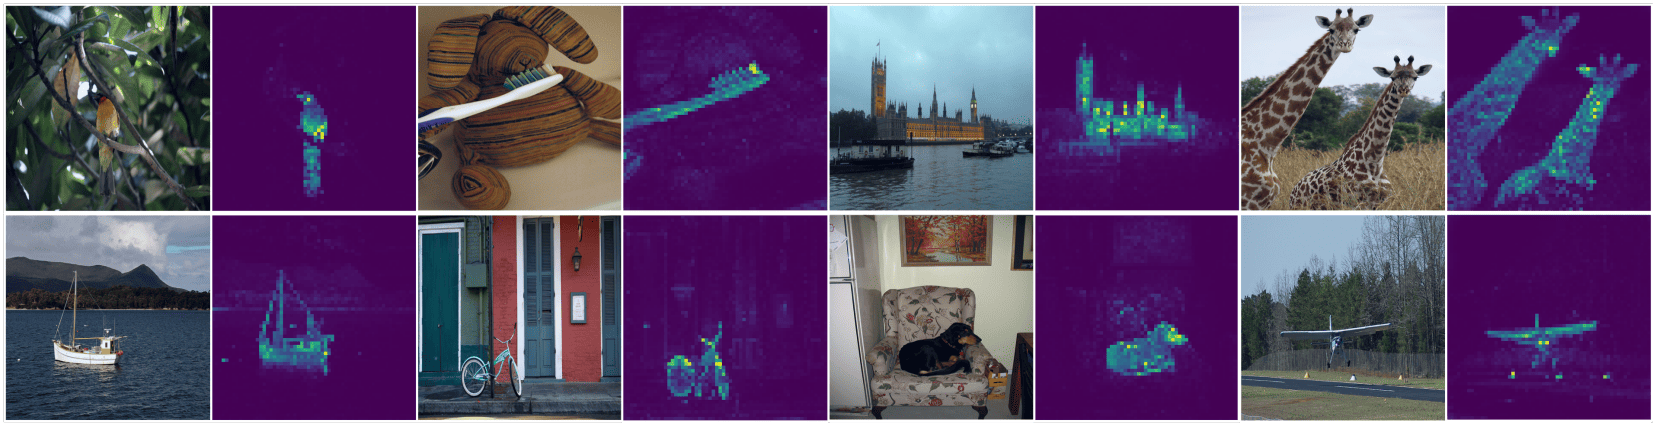

`DINOv2 (2023)` [Статья](https://arxiv.org/abs/2304.07193) | 4955 цитирований

`DINO v3 (2025)` [Статья](https://arxiv.org/abs/2508.10104) | 34 цитирований на момемент 5 октября 2025, дата публикации 13 августа 2025

### `Дистилляция в диффузионных моделей (2023)`

[Статья](https://arxiv.org/abs/2311.17042) | 573 цитирований

На изображениях возникает своя особенность, например, часто мы не можем повторить большую модель достаточно хорошо и в точности получить её выход, поэтому бывает полезно добавить состязательное обучение.

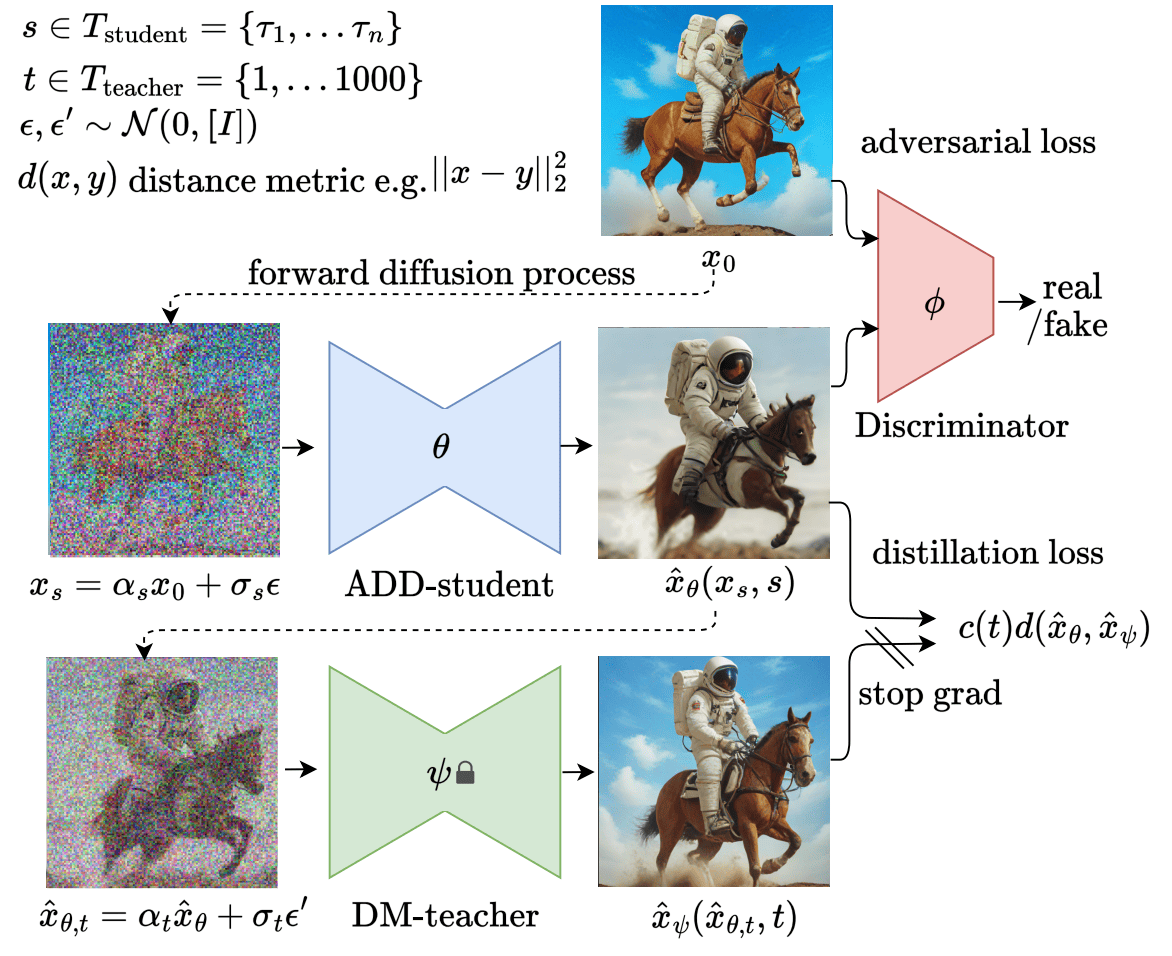

Adversarial Diffusion Distillation | [Источник](https://arxiv.org/abs/2311.17042)

На самом деле, существует много примеров дистилляции для диффузионных моделей: consistency models, progressive distillation и другие. Мы их не рассматриваем, так как там нужно чуть больше знаний о диффузионных моделей. Подробнее можете почитать в оригинальных статьях или узнать на специализированных курсах, например, как [этот](http://wiki.cs.hse.ru/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D0%BD%D0%B0_%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5_%D0%B4%D0%B8%D1%84%D1%84%D1%83%D0%B7%D0%B8%D0%B8_(25/26)). 

### `Дистилляция в LLM: MiniLLM (2023)`

[Статья](https://arxiv.org/abs/2306.08543) | 552 цитирований

В случае дистилляции классификаторов, мы добавляли $KL[p^T \| p^S]$ и это работало хорошо, в случае генерации текстов на практике это работает плохо. При этом лучше работает оптимизация $KL[p^S \| p^T]$.

#### **Вопрос**. Почему Forward KL может работать плохо, а Reverse KL справляется с задачей хорошо? 

*Подсказка*. Вспомните про GAN. 

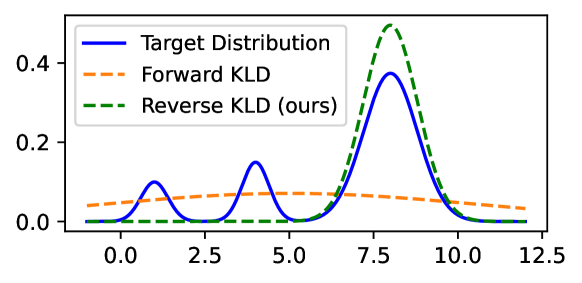

Влияние KL | [Источник](https://arxiv.org/abs/2306.08543)

Такой эффект наблюдается, так как в классификации чаще существует один подходящий класс. В случае генерации текста, часто мод много, так как продолжить текст можно разными способами.

Правда возникает проблема, что оптимизация $KL[p^S \| p^T]$ по параметрам $p^S$ значительно труднее, чем например по параметрам $p^T$. Для этого нужно использовать подходы из reinforcement learning, так как мы начинаем оптимизировать $\mathbb{E}_{p^S} \log \frac{p^S}{p^T}$. Оптимизируемые параметры есть в функции внутри математического ожидания и в том, по чему берем математическое ожидание. Мы не можем явно применить Монте-Карло оценку градиента. Подробнее узнаете на курсе по обучению с подкреплением и курсе Байесовских Методов.


У методов reinforcement learning часто долгая сходимость, высокая дисперсия градиентов и много трюков. Мы не будем останавливаться на этом, а представим, что задачу оптимизации $KL[p^S \| p^T]$ мы можем решить (хоть и не тривиально).

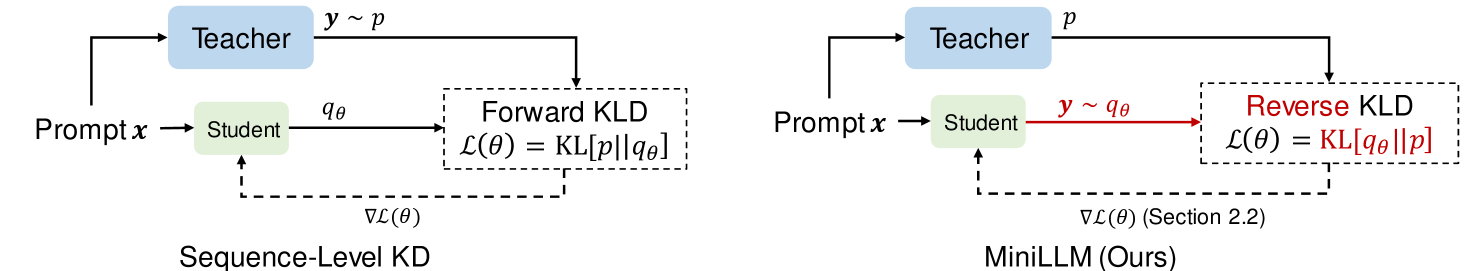

Метод | [Источник](https://arxiv.org/abs/2306.08543)

#### `Кратко про обучение MiniLLM (если есть базовые знания по RL)`

В случаи обучения языковых моделей мы предсказываем следующий токен на основе всех предыдущих, то есть мы оптимизируем функционал:

\begin{align}
\mathbb{E}_{y \sim p^S_{\theta}(y \mid x)} \log \frac{p^S_{\theta}(y \mid x)}{p^T(y \mid x)} \to \min_{\theta},
\end{align}
где $x$ — контекст, $y$ — следующий токен. Пока представим, что $y$ это один новый токен.


Мы можем воспринимать $p^S_{\theta}(y \mid x)$ как некоторую обучающую политику. Тогда мы можем обозначить $\log \frac{p^S_{\theta}(y \mid x)}{p^T(y \mid x)}$ за $Q$ функцию для состояния $x$ и действия $a$, а оптимизируемый функционал $V$ функция. 

\begin{align}
V_{\theta}(x) := \mathbb{E}_{y \sim p^S_{\theta}(y \mid x)} Q_{\theta}(x, y) \to \min_{\theta}.
\end{align}

Кроме того, мы знаем, что политика дифференцируема по $\theta$, а значит:

\begin{align}
\nabla_{\theta} V_{\theta}(x) = \mathbb{E}_{y \sim p^S_{\theta}(y \mid x)} \bigl[\nabla_\theta \log p^S_{\theta}(y \mid x) Q_{\theta}(x, y) + \nabla_{\theta} Q_{\theta}(x, y) \bigr].
\end{align}

Далее мы можем стандартно расписать $Q$ через $Q$ и $V$ через $V$. Нас же интересует оптимизация когда $y$ это не один токен, а последовательность сгенерированная с помощью Student (политики). Тогда можно воспользоваться Policy Gradient Theorem (прочитать можно в  [Reinforcement Learning Textbook](https://arxiv.org/abs/2201.09746)).

У такого подхода будет высокая дисперсия стохастических градиентов и он будет плохо учиться, поэтому, как часто бывает в RL, авторы используют разные трюки:

- Single-Step Decomposition: Разбить функцию награды на награду на первом шаге и на всех последующих. К награде для всех будущих шагов применить Length Normalization;

- Teacher-Mixed Sampling: семплировать следующий токен не только из Student, а из смеси выходов Student и Teacher;

- Length Normalization: нормализацию на длину $y$.

Цель данной секции продемонстрировать специфику дистилляции в обучении LLM.

#### `Результаты MiniLLM`

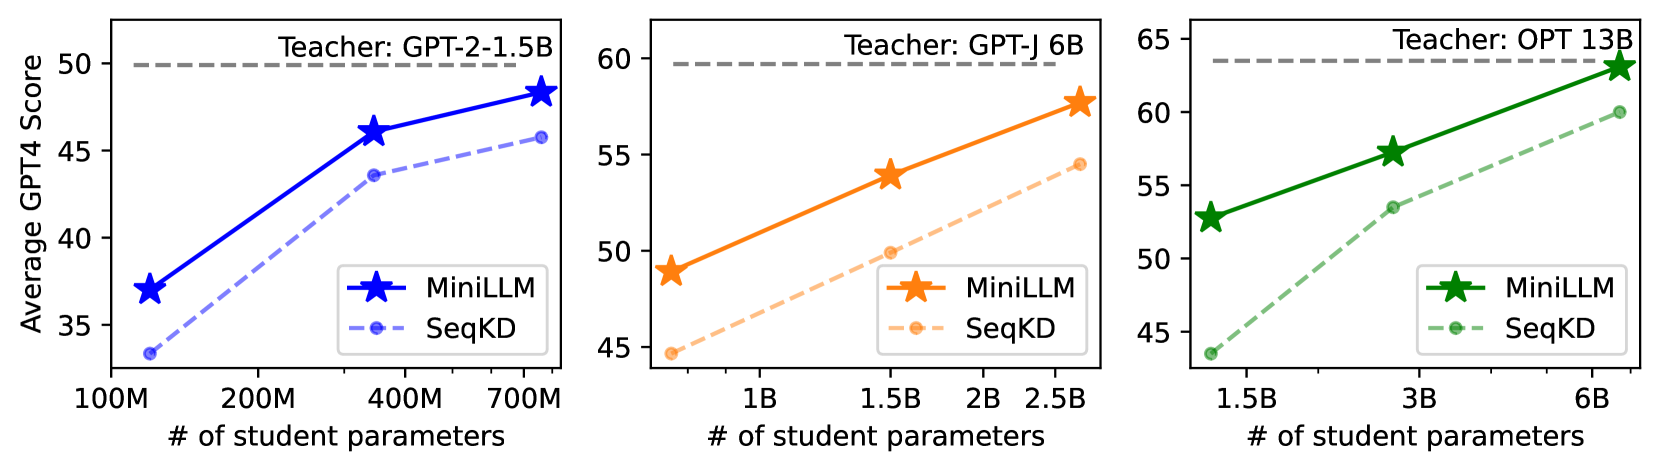

Результаты | [Источник](https://arxiv.org/abs/2306.08543)

## `Fast Inference from Transformers via Speculative Decoding (2022)`

[Статья](https://arxiv.org/abs/2211.17192) | 882 цитирований

[Хороший блогпост](https://research.google/blog/looking-back-at-speculative-decoding/)

Выше мы научились дистиллировать большие модели в маленькие и знаем, что этот способ применим LLM и он работает! 

На самом деле, трансформеры сами по себе хорошо масштабируемы, поэтому очень часто у нас есть small, middle и large модели с одной архитектурой. Например, small имеет 1 млрд параметров, а large может все 70 млрд. 

Возникает вопрос, как использовать все что мы прошли на практике, а именно появляется вопрос:

**Как ускорить генерацию текста с помощью LLM?**

Сделаем 2 важных наблюдения:

- Есть простые токены, а есть сложные. Например, чтобы продолжить текст "У лукоморье дуб зелёный ...", нам не нужна большая модель. В случае текста "Интеграл икс по dx от -1 до 5 будет равен ..." следующий токен может быть трудный для маленькой модели, но понятен для большой модели.

- Современные LLM, а в частности блоки трансформеров, быстро считаются и параллелятся, но требуют огромной памяти в случае очень больших моделей. Если мы подгрузим слой трансформера в память, то мы у нас будет достаточно много ресурсов запускать его параллельно. Основная проблема в подгрузке слоя.

### `Speculative execution`

Для простоты ещё представим процесс авторегрессионный генерации следующим способом:
    
\begin{equation}
x^{k+1} = f(x^k).
\end{equation}

Где функция $f$ хорошо параллелится, но сама по себе долго вычисляется. Кроме того у функции $f$ есть хорошая аппроксимация $g$, которая быстро вычисляется.

#### **Вопрос**. Как вы будете генерировать последовательность $x^k$ быстро?

**Ответ**. Попробуем сгенерировать всю последовательность через $g$, это сделать можно очень быстро. Получим:

\begin{align}
\hat{x}^{k+1} &= g(\hat{x}^k),\\
\hat{x}^0 &= x^k
\end{align}

Далее параллельно будем проверять, что $\hat{x}^{k+1} = f(\hat{x}^k)$, если это равенство выполнено всегда, то значит аппроксимация всегда хорошо сработала и $\hat{x}^{k} == x^{k}$.

Если где-то случилось отличие, то значит в этом месте мы сломались и надо честно посчитать функцию. Далее повторяем идею.


Такой подход называется [Speculative execution](https://en.wikipedia.org/wiki/Speculative_execution). 

### `Speculative sampling`

Выше мы немного упростили задачу, так как генерация токенов это недетерминированный алгоритм, а процесс семплирования:

\begin{equation}
x^{k+1} \sim f(x^k).
\end{equation}

Мы можем повторить те же рассуждения, но теперь нам нужно проверять не точное равенство, так как проверять равенство случайных величин не очень здравая идея. Нам нужно чтобы распределения из аппроксимации $g$ и настоящий $f$ совпадали.

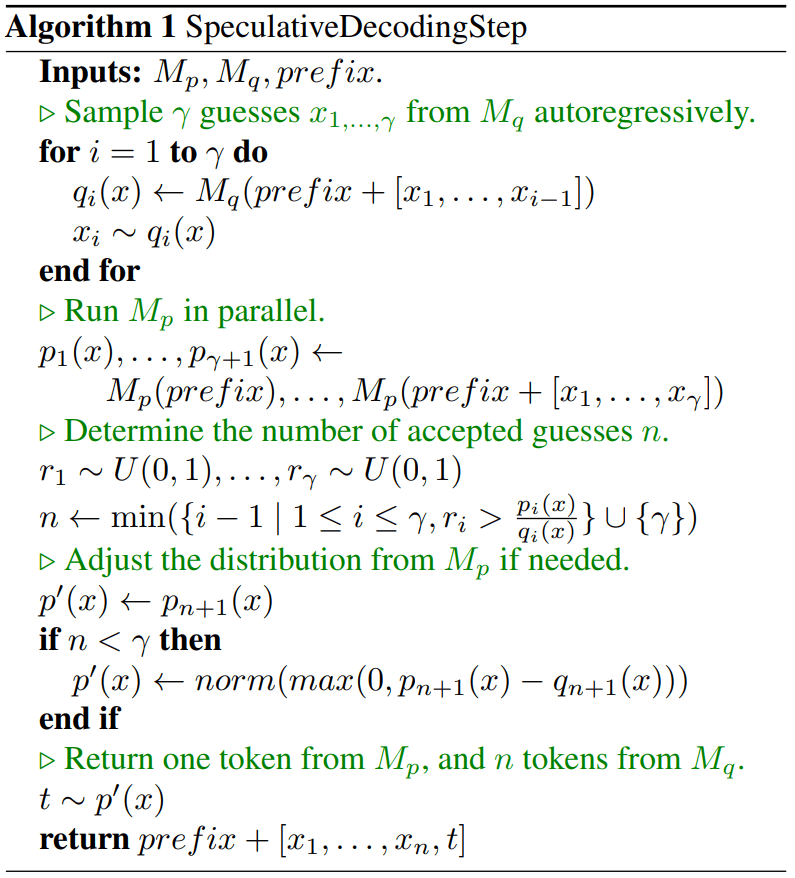

Алгоритм Speculative sampling | [Источник](https://arxiv.org/abs/2211.17192)

Лучше вернуться к осознанию алгоритма после лекции по методам семплированиям из курса Байесовских методов. Так как алгоритм очень похож на известный метод Rejection Sampling. Идейно благодаря условию на принятия и отвержение, мы можем семплировать из другого распределения $q$, но получать итоговое распределение семплов из $p$.

### `Speculative decoding`

[Наглядное видео](https://storage.googleapis.com/gweb-research2023-media/media/SpeculativeDecoding-1-Illustration.mp4)

Если мы генерируем жадно, то нам для генерации текста подойдет `Speculative execution`, если мы каждый раз сэмплируем новый токен, то  `Speculative sampling`. Единственное, что нужно, — это быстрая аппроксимация, которая будет хорошо предсказывать простые токены. Её можно получить либо с помощью дистилляции, либо через масштабирование трансформера.


На практике для ускорения 11B T5-XXL модели для задачи перевода, использовали аппроксимацию маленькой моделью на 60M T5-small и получили ускорение в ~3x.

## `Дополнительно может быть интересно`

Это список работ, который могут вам интересны, но ссылки на которые нет выше.


1) Как выбирать архитектуры студента и как они влияют на дистилляцию? [Статья](https://arxiv.org/abs/2310.19444) | 135 цитирований, работа 2023 года

2) Что будет если учить студента и учителя одновременно? [Статья](https://arxiv.org/abs/1706.00384) | 2391 цитирований, работа 2017 года

3) Метод самодистиляции, на котором основано DINO. [Статья](https://arxiv.org/abs/2006.07733) | 9218 цитирований, работа 2020 года

4) Если выбрать учителя слишком сильным, то ничего не обучится? [Статья](https://arxiv.org/abs/1910.01348) | 982 цитирований, работа 2019 года

5) Почему иногда студент превосходит учителя? [Статья](https://arxiv.org/abs/1805.04770) | 1390 цитирований, работа 2018 года

6) Почему задача дистилляции трудная и имеет много локальных минимумов? [Статья](https://arxiv.org/abs/2106.05945) | 322 цитирований, работа 2021 года